In [1]:
import jax.numpy as jnp
import diffrax
import jax
jax.config.update('jax_enable_x64',True)

from jax.random import key
import matplotlib.pyplot as plt

In [2]:
delta = 0.5
alpha = 1.
beta = 10.
def duffing_term(t,x,args=None):
    xdot = jnp.array(
		[
            x[1],
            -delta * x[1] - alpha * x[0] - beta * x[0]**3
		]
	)
    return xdot
    
dt0 = 0.005
T = 50
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)

x0 = jnp.array([1.,0.])

sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(duffing_term),
	solver = diffrax.Tsit5(),
	t0=0.,
	t1=T,
	dt0=dt0,
	y0=x0,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0))
)

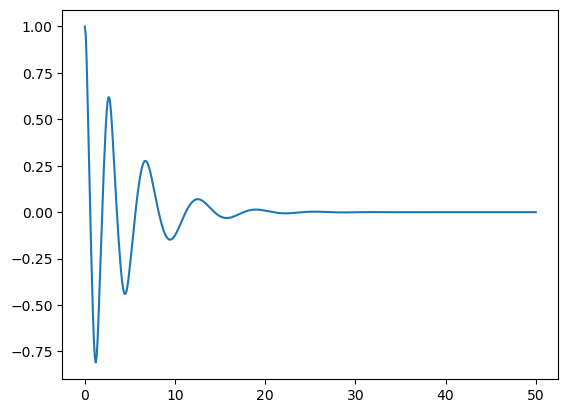

In [3]:
t_grid = jnp.linspace(0,T,500)
plt.plot(t_grid,jax.vmap(sol.evaluate)(t_grid)[:,0])

In [10]:
n = 5
mu = -1.
gamma = 20.
omega = 0.25

delta_vals = 0. * jnp.ones(n)
alpha_vals = jax.random.uniform(key(12),(n,),minval = 2,maxval = 4)
beta_vals = 2 * jnp.ones(n)
all_args = jnp.vstack([delta_vals,alpha_vals,beta_vals]).T



def duffing_term(t,x,args):
    delta,alpha,beta = args
    xdot = jnp.array(
		[
            x[1],
            -delta * x[1] - alpha * x[0] - beta * x[0]**3
		]
	)
    return xdot


duffing_damp = jax.vmap(duffing_term,in_axes=(None,0,0))

K = jnp.zeros(n)
K = jnp.diag(jnp.ones(n-1),1)
K = K + jnp.diag(jnp.ones(n-1),-1)
K = K.at[(0,n-1),(n-1,0)].set(1.)

K = K - jnp.diag(jnp.sum(K,axis=0))

In [11]:
initial_conditions = jnp.vstack([jnp.linspace(-2,2,n),jnp.zeros(n)]).T

initial_conditions = jnp.vstack([
    jax.random.normal(key(23),n),
    jax.random.normal(key(133),n)
    ]).T

initial_conditions = jnp.vstack([jnp.ones(n),jnp.zeros(n)]).T



def linear_coupling(x):
    states = x[:,0]
    coupling_term = K@states
    full_term = mu * jnp.hstack([jnp.zeros((n,1)),coupling_term[:,None]])
    return full_term

def ode_f(t,x,args):
    return duffing_damp(t,x,args) + linear_coupling(x)# + gamma * jnp.array([0,jnp.cos(omega*t)])


dt0 = 0.005
T = 30
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)
sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(ode_f),
	solver = diffrax.Tsit5(),
	t0=0.,
	t1=T,
	dt0=dt0,
	y0=initial_conditions,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0)),
    args = all_args
)

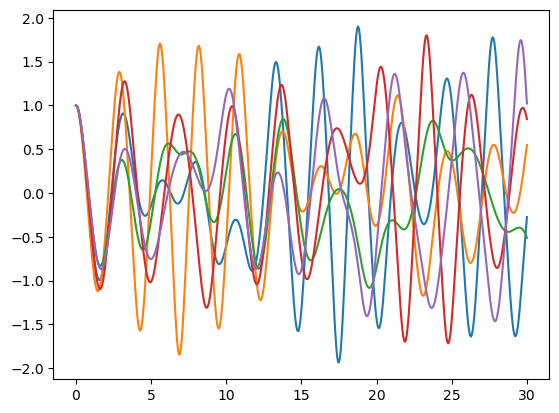

In [12]:
t_grid = jnp.linspace(0,T,500)
values = jax.vmap(lambda t:sol.evaluate(t)[:,0])(t_grid)
for col in values.T:
    plt.plot(t_grid,col)